In [1]:
'''
!pip install Cython
!git clone https://github.com/waleedka/coco.git

!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI
'''

'\n!pip install Cython\n!git clone https://github.com/waleedka/coco.git\n\n!pip install -U setuptools\n!pip install -U wheel\n!make install -C coco/PythonAPI\n'

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
import datetime
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler



# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model_h as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/interior/"))  # To find local version
import interior_seq

%matplotlib inline 
%load_ext tensorboard

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dty

/media/scratch1/erbachj/Mask_RCNN
The tensorboard module is not an IPython extension.
finished


In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [5]:
class_names = ['BG', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
               'table', 'door', 'window', 'bookshelf', 'picture', 'counter',
               'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 
               'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator',
               'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 
               'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 
               'otherstructure', 'otherfurniture', 'otherprop']

selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'curtain', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
# without curtain
selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 
                    'picture', 'blinds', 'shelves', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
print(class_names[15])

shelves


In [6]:
NYU40_to_sel_map = {}
selected_class_list = []

for i in range(len(class_names)):
    if class_names[i] in selected_classes:
        NYU40_to_sel_map[i] = selected_classes.index(class_names[i])
        selected_class_list.append(i)
    else:
        NYU40_to_sel_map[i] = 0
NYU40_to_sel_map[class_names.index('desk')] = selected_classes.index('table')
NYU40_to_sel_map[class_names.index('bookshelf')] = selected_classes.index('shelves')
NYU40_to_sel_map[class_names.index('refridgerator')] = selected_classes.index('refrigerator')
selected_class_list.append(class_names.index('desk'))
selected_class_list.append(class_names.index('bookshelf'))
selected_class_list.append(class_names.index('refridgerator'))

"""
NYU40_to_sel_map = {'BG': 'BG', 'wall': 'BG', 'floor': 'BG', 'cabinet': 'cabinet', 
                    'bed': 'bed', 'chair': 'chair', 'sofa': 'sofa', 'table': 'table', 
                    'door': 'BG', 'window': 'window', 'bookshelf': 'shelves', 
                    'picture': 'picture', 'counter': 'BG', 'blinds': 'blinds', 
                    'desk': 'table', 'shelves': 'shelves', 'curtain': 'curtain', 
                    'dresser': 'dresser', 'pillow': 'pillow', 'mirror': 'mirror', 
                    'clothes': 'clothes', 'ceiling': 'BG', 'books': 'books', 
                    'refridgerator': 'refrigerator', 'television': 'television', 
                    'paper': 'paper', 'towel': 'towel', 'shower': 'BG', 'box': 'BG', 
                    'whiteboard': 'BG', 'person': 'BG', 'night': 'BG', 'toilet': 'toilet',
                    'sink': 'sink', 'lamp': 'lamp', 'bathtub': 'bathtub', 'bag': 'bag', 
                    'otherstructure': 'BG', 'otherfurniture': 'BG', 'otherprop': 'BG'}
"""

print(NYU40_to_sel_map)
print(selected_class_list)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 0, 9: 0, 10: 8, 11: 6, 12: 0, 13: 7, 14: 5, 15: 8, 16: 0, 17: 9, 18: 10, 19: 11, 20: 0, 21: 12, 22: 0, 23: 13, 24: 14, 25: 15, 26: 16, 27: 17, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 18, 34: 19, 35: 20, 36: 21, 37: 22, 38: 0, 39: 0, 40: 0}
[0, 3, 4, 5, 6, 7, 11, 13, 15, 17, 18, 19, 21, 23, 25, 26, 27, 33, 34, 35, 36, 37, 14, 10, 24]


In [7]:
#TRAIN_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDDWIQX7_Dining_room'
#TRAIN_DIR = os.path.join(TRAIN_DIR,'cam0/data/')
TRAIN_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')
print(TRAIN_DIR)
# Training dataset
dataset_train = interior_seq.InteriorDataset()
dataset_train.load_Interior(dataset_dir=TRAIN_DIR, subset='train', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_train.prepare()

# Validation dataset
#VAL_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDEI1LAV_Dining_room'
#VAL_DIR = os.path.join(VAL_DIR,'cam0/data/')
VAL_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')

dataset_val = interior_seq.InteriorDataset()
dataset_val.load_Interior(dataset_dir=VAL_DIR, subset='val', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_val.prepare()

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7
HD7
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMIGOGN1_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMIGOGN1_Bedroom_id0
3FO4MMIGOGN1_Bedroom_id1
3FO4MMIGOGN1_Bedroom_id2
3FO4MMIGOGN1_Bedroom_id3
3FO4MMIGOGN1_Bedroom_id4
3FO4MMIGOGN1_Bedroom_id5
3FO4MMIGOGN1_Bedroom_id6
3FO4MMIGOGN1_Bedroom_id7
3FO4MMIGOGN1_Bedroom_id8
3FO4MMIGOGN1_Bedroom_id9
3FO4MMIGOGN1_Bedroom_id10
3FO4MMIGOGN1_Bedroom_id11
3FO4MMIGOGN1_Bedroom_id12
3FO4MMIGOGN1_Bedroom_id13
3FO4MMIGOGN1_Bedroom_id14
3FO4MMIGOGN1_Bedroom_id15
3FO4MMIGOGN1_Bedroom_id16
3FO4MMIGOGN1_Bedroom_id17
3FO4MMIGOGN1_Bedroom_id18
3FO4MMIGOGN1_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV6CI92_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKV6CI92_Living_room_id0
3FO4MKV6CI92_Living_room_id1
3FO4MKV6CI92_Living_room

3FO4MLXT9MIE_Living_room_id8
3FO4MLXT9MIE_Living_room_id10
3FO4MLXT9MIE_Living_room_id11
3FO4MLXT9MIE_Living_room_id13
3FO4MLXT9MIE_Living_room_id14
3FO4MLXT9MIE_Living_room_id15
3FO4MLXT9MIE_Living_room_id16
3FO4MLXT9MIE_Living_room_id17
3FO4MLXT9MIE_Living_room_id18
3FO4MLXT9MIE_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV6BTTU_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKV6BTTU_Living_room_id0
3FO4MKV6BTTU_Living_room_id1
3FO4MKV6BTTU_Living_room_id2
3FO4MKV6BTTU_Living_room_id3
3FO4MKV6BTTU_Living_room_id4
3FO4MKV6BTTU_Living_room_id5
3FO4MKV6BTTU_Living_room_id6
3FO4MKV6BTTU_Living_room_id7
3FO4MKV6BTTU_Living_room_id8
3FO4MKV6BTTU_Living_room_id9
3FO4MKV6BTTU_Living_room_id10
3FO4MKV6BTTU_Living_room_id11
3FO4MKV6BTTU_Living_room_id12
3FO4MKV6BTTU_Living_room_id13
3FO4MKV6BTTU_Living_room_id14
3FO4MKV6BTTU_Living_room_id15
3FO4MKV6BTTU_Living_room_id16
3FO4MKV6BTTU_Living_room_id

Done (t=0.00s)
creating index...
index created!
3FO4MEQ1XK0U_Living_room_id0
3FO4MEQ1XK0U_Living_room_id1
3FO4MEQ1XK0U_Living_room_id2
3FO4MEQ1XK0U_Living_room_id3
3FO4MEQ1XK0U_Living_room_id4
3FO4MEQ1XK0U_Living_room_id5
3FO4MEQ1XK0U_Living_room_id6
3FO4MEQ1XK0U_Living_room_id7
3FO4MEQ1XK0U_Living_room_id8
3FO4MEQ1XK0U_Living_room_id9
3FO4MEQ1XK0U_Living_room_id10
3FO4MEQ1XK0U_Living_room_id11
3FO4MEQ1XK0U_Living_room_id12
3FO4MEQ1XK0U_Living_room_id13
3FO4MEQ1XK0U_Living_room_id14
3FO4MEQ1XK0U_Living_room_id15
3FO4MEQ1XK0U_Living_room_id16
3FO4MEQ1XK0U_Living_room_id17
3FO4MEQ1XK0U_Living_room_id18
3FO4MEQ1XK0U_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MEGCJMM7_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEGCJMM7_Living_room_id0
3FO4MEGCJMM7_Living_room_id1
3FO4MEGCJMM7_Living_room_id2
3FO4MEGCJMM7_Living_room_id3
3FO4MEGCJMM7_Living_room_id4
3FO4MEGCJMM7_Living_room_id5
3FO4MEGCJMM7_L

3FO4MLXUMV2T_Living_room_id16
3FO4MLXUMV2T_Living_room_id17
3FO4MLXUMV2T_Living_room_id18
3FO4MLXUMV2T_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIN18PB8_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIN18PB8_Living_room_id0
3FO4MIN18PB8_Living_room_id2
3FO4MIN18PB8_Living_room_id3
3FO4MIN18PB8_Living_room_id4
3FO4MIN18PB8_Living_room_id5
3FO4MIN18PB8_Living_room_id6
3FO4MIN18PB8_Living_room_id7
3FO4MIN18PB8_Living_room_id8
3FO4MIN18PB8_Living_room_id9
3FO4MIN18PB8_Living_room_id10
3FO4MIN18PB8_Living_room_id11
3FO4MIN18PB8_Living_room_id12
3FO4MIN18PB8_Living_room_id13
3FO4MIN18PB8_Living_room_id14
3FO4MIN18PB8_Living_room_id15
3FO4MIN18PB8_Living_room_id16
3FO4MIN18PB8_Living_room_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MCD8XIBX_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MCD8XIBX_Dining_room_id0
3F

3FO4MEOI6X14_Dining_room_id3
3FO4MEOI6X14_Dining_room_id4
3FO4MEOI6X14_Dining_room_id5
3FO4MEOI6X14_Dining_room_id6
3FO4MEOI6X14_Dining_room_id7
3FO4MEOI6X14_Dining_room_id8
3FO4MEOI6X14_Dining_room_id9
3FO4MEOI6X14_Dining_room_id10
3FO4MEOI6X14_Dining_room_id11
3FO4MEOI6X14_Dining_room_id12
3FO4MEOI6X14_Dining_room_id13
3FO4MEOI6X14_Dining_room_id14
3FO4MEOI6X14_Dining_room_id15
3FO4MEOI6X14_Dining_room_id16
3FO4MEOI6X14_Dining_room_id17
3FO4MEOI6X14_Dining_room_id18
3FO4MEOI6X14_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMJN3SIH_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMJN3SIH_Guest_room_id0
3FO4MMJN3SIH_Guest_room_id2
3FO4MMJN3SIH_Guest_room_id3
3FO4MMJN3SIH_Guest_room_id5
3FO4MMJN3SIH_Guest_room_id6
3FO4MMJN3SIH_Guest_room_id7
3FO4MMJN3SIH_Guest_room_id8
3FO4MMJN3SIH_Guest_room_id9
3FO4MMJN3SIH_Guest_room_id11
3FO4MMJN3SIH_Guest_room_id12
3FO4MMJN3SIH_Guest_room_id15
3FO4MMJN3SIH_

3FO4MM1UORDH_Bedroom_id0
3FO4MM1UORDH_Bedroom_id1
3FO4MM1UORDH_Bedroom_id2
3FO4MM1UORDH_Bedroom_id3
3FO4MM1UORDH_Bedroom_id4
3FO4MM1UORDH_Bedroom_id5
3FO4MM1UORDH_Bedroom_id6
3FO4MM1UORDH_Bedroom_id7
3FO4MM1UORDH_Bedroom_id8
3FO4MM1UORDH_Bedroom_id9
3FO4MM1UORDH_Bedroom_id10
3FO4MM1UORDH_Bedroom_id11
3FO4MM1UORDH_Bedroom_id12
3FO4MM1UORDH_Bedroom_id13
3FO4MM1UORDH_Bedroom_id14
3FO4MM1UORDH_Bedroom_id15
3FO4MM1UORDH_Bedroom_id16
3FO4MM1UORDH_Bedroom_id17
3FO4MM1UORDH_Bedroom_id18
3FO4MM1UORDH_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHNXR7X0_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHNXR7X0_Living_room_id0
3FO4MHNXR7X0_Living_room_id1
3FO4MHNXR7X0_Living_room_id2
3FO4MHNXR7X0_Living_room_id3
3FO4MHNXR7X0_Living_room_id4
3FO4MHNXR7X0_Living_room_id5
3FO4MHNXR7X0_Living_room_id6
3FO4MHNXR7X0_Living_room_id7
3FO4MHNXR7X0_Living_room_id8
3FO4MHNXR7X0_Living_room_id9
3FO4MHNXR7X0_Living_room_i

3FO4MFPOFVKO_Living_room_id2
3FO4MFPOFVKO_Living_room_id3
3FO4MFPOFVKO_Living_room_id4
3FO4MFPOFVKO_Living_room_id5
3FO4MFPOFVKO_Living_room_id6
3FO4MFPOFVKO_Living_room_id7
3FO4MFPOFVKO_Living_room_id8
3FO4MFPOFVKO_Living_room_id9
3FO4MFPOFVKO_Living_room_id10
3FO4MFPOFVKO_Living_room_id11
3FO4MFPOFVKO_Living_room_id12
3FO4MFPOFVKO_Living_room_id13
3FO4MFPOFVKO_Living_room_id14
3FO4MFPOFVKO_Living_room_id15
3FO4MFPOFVKO_Living_room_id16
3FO4MFPOFVKO_Living_room_id17
3FO4MFPOFVKO_Living_room_id18
3FO4MFPOFVKO_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MF6RQ9VA_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MF6RQ9VA_Guest_room_id0
3FO4MF6RQ9VA_Guest_room_id1
3FO4MF6RQ9VA_Guest_room_id2
3FO4MF6RQ9VA_Guest_room_id3
3FO4MF6RQ9VA_Guest_room_id4
3FO4MF6RQ9VA_Guest_room_id5
3FO4MF6RQ9VA_Guest_room_id6
3FO4MF6RQ9VA_Guest_room_id7
3FO4MF6RQ9VA_Guest_room_id8
3FO4MF6RQ9VA_Guest_room_id9
3FO4MF6RQ9VA_Gu

Done (t=0.00s)
creating index...
index created!
3FO4MEVAB1A5_Living_room_id0
3FO4MEVAB1A5_Living_room_id1
3FO4MEVAB1A5_Living_room_id2
3FO4MEVAB1A5_Living_room_id3
3FO4MEVAB1A5_Living_room_id4
3FO4MEVAB1A5_Living_room_id5
3FO4MEVAB1A5_Living_room_id6
3FO4MEVAB1A5_Living_room_id7
3FO4MEVAB1A5_Living_room_id8
3FO4MEVAB1A5_Living_room_id9
3FO4MEVAB1A5_Living_room_id10
3FO4MEVAB1A5_Living_room_id11
3FO4MEVAB1A5_Living_room_id12
3FO4MEVAB1A5_Living_room_id13
3FO4MEVAB1A5_Living_room_id14
3FO4MEVAB1A5_Living_room_id15
3FO4MEVAB1A5_Living_room_id16
3FO4MEVAB1A5_Living_room_id17
3FO4MEVAB1A5_Living_room_id18
3FO4MEVAB1A5_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIN0295T_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIN0295T_Guest_room_id0
3FO4MIN0295T_Guest_room_id1
3FO4MIN0295T_Guest_room_id2
3FO4MIN0295T_Guest_room_id3
3FO4MIN0295T_Guest_room_id4
3FO4MIN0295T_Guest_room_id5
3FO4MIN0295T_Guest_ro

3FO4METFL4GR_Dining_room_id15
3FO4METFL4GR_Dining_room_id16
3FO4METFL4GR_Dining_room_id17
3FO4METFL4GR_Dining_room_id18
3FO4METFL4GR_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M4Y0L7VD_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M4Y0L7VD_Guest_room_id1
3FO4M4Y0L7VD_Guest_room_id5
3FO4M4Y0L7VD_Guest_room_id8
3FO4M4Y0L7VD_Guest_room_id9
3FO4M4Y0L7VD_Guest_room_id11
3FO4M4Y0L7VD_Guest_room_id12
3FO4M4Y0L7VD_Guest_room_id13
3FO4M4Y0L7VD_Guest_room_id17
3FO4M4Y0L7VD_Guest_room_id18
3FO4M4Y0L7VD_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMJN6UIE_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMJN6UIE_Bedroom_id0
3FO4MMJN6UIE_Bedroom_id1
3FO4MMJN6UIE_Bedroom_id2
3FO4MMJN6UIE_Bedroom_id3
3FO4MMJN6UIE_Bedroom_id4
3FO4MMJN6UIE_Bedroom_id5
3FO4MMJN6UIE_Bedroom_id6
3FO4MMJN6UIE_Bedroom_id7
3FO4MMJN6UIE_Bedroom_

3FO4MLXQVP7L_Living_room_id0
3FO4MLXQVP7L_Living_room_id1
3FO4MLXQVP7L_Living_room_id2
3FO4MLXQVP7L_Living_room_id3
3FO4MLXQVP7L_Living_room_id4
3FO4MLXQVP7L_Living_room_id5
3FO4MLXQVP7L_Living_room_id6
3FO4MLXQVP7L_Living_room_id7
3FO4MLXQVP7L_Living_room_id8
3FO4MLXQVP7L_Living_room_id9
3FO4MLXQVP7L_Living_room_id10
3FO4MLXQVP7L_Living_room_id11
3FO4MLXQVP7L_Living_room_id12
3FO4MLXQVP7L_Living_room_id13
3FO4MLXQVP7L_Living_room_id14
3FO4MLXQVP7L_Living_room_id15
3FO4MLXQVP7L_Living_room_id16
3FO4MLXQVP7L_Living_room_id17
3FO4MLXQVP7L_Living_room_id18
3FO4MLXQVP7L_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKG1XL3K_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKG1XL3K_Living_room_id0
3FO4MKG1XL3K_Living_room_id1
3FO4MKG1XL3K_Living_room_id2
3FO4MKG1XL3K_Living_room_id3
3FO4MKG1XL3K_Living_room_id4
3FO4MKG1XL3K_Living_room_id5
3FO4MKG1XL3K_Living_room_id6
3FO4MKG1XL3K_Living_room_id7
3FO4

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MBFIS3J0_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MBFIS3J0_Dining_room_id0
3FO4MBFIS3J0_Dining_room_id1
3FO4MBFIS3J0_Dining_room_id2
3FO4MBFIS3J0_Dining_room_id3
3FO4MBFIS3J0_Dining_room_id4
3FO4MBFIS3J0_Dining_room_id5
3FO4MBFIS3J0_Dining_room_id6
3FO4MBFIS3J0_Dining_room_id7
3FO4MBFIS3J0_Dining_room_id8
3FO4MBFIS3J0_Dining_room_id9
3FO4MBFIS3J0_Dining_room_id10
3FO4MBFIS3J0_Dining_room_id11
3FO4MBFIS3J0_Dining_room_id12
3FO4MBFIS3J0_Dining_room_id13
3FO4MBFIS3J0_Dining_room_id14
3FO4MBFIS3J0_Dining_room_id15
3FO4MBFIS3J0_Dining_room_id16
3FO4MBFIS3J0_Dining_room_id17
3FO4MBFIS3J0_Dining_room_id18
3FO4MBFIS3J0_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MD4YMHX9_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MD4YMHX9_Dining_room_id0
3FO4MD4YMHX9_Dining_room_id1
3FO4

Done (t=0.00s)
creating index...
index created!
3FO4MB531189_Dining_room_id1
3FO4MB531189_Dining_room_id2
3FO4MB531189_Dining_room_id3
3FO4MB531189_Dining_room_id4
3FO4MB531189_Dining_room_id5
3FO4MB531189_Dining_room_id6
3FO4MB531189_Dining_room_id7
3FO4MB531189_Dining_room_id8
3FO4MB531189_Dining_room_id9
3FO4MB531189_Dining_room_id10
3FO4MB531189_Dining_room_id11
3FO4MB531189_Dining_room_id12
3FO4MB531189_Dining_room_id13
3FO4MB531189_Dining_room_id14
3FO4MB531189_Dining_room_id17
3FO4MB531189_Dining_room_id18
3FO4MB531189_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLT2TAC7_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLT2TAC7_Living_room_id0
3FO4MLT2TAC7_Living_room_id1
3FO4MLT2TAC7_Living_room_id3
3FO4MLT2TAC7_Living_room_id4
3FO4MLT2TAC7_Living_room_id5
3FO4MLT2TAC7_Living_room_id6
3FO4MLT2TAC7_Living_room_id7
3FO4MLT2TAC7_Living_room_id8
3FO4MLT2TAC7_Living_room_id9
3FO4MLT2TAC7_Liv

3FO4MEFFLBKQ_Living_room_id18
3FO4MEFFLBKQ_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKUOI2RR_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKUOI2RR_Living_room_id0
3FO4MKUOI2RR_Living_room_id1
3FO4MKUOI2RR_Living_room_id2
3FO4MKUOI2RR_Living_room_id3
3FO4MKUOI2RR_Living_room_id4
3FO4MKUOI2RR_Living_room_id5
3FO4MKUOI2RR_Living_room_id6
3FO4MKUOI2RR_Living_room_id7
3FO4MKUOI2RR_Living_room_id8
3FO4MKUOI2RR_Living_room_id9
3FO4MKUOI2RR_Living_room_id10
3FO4MKUOI2RR_Living_room_id11
3FO4MKUOI2RR_Living_room_id12
3FO4MKUOI2RR_Living_room_id13
3FO4MKUOI2RR_Living_room_id14
3FO4MKUOI2RR_Living_room_id15
3FO4MKUOI2RR_Living_room_id16
3FO4MKUOI2RR_Living_room_id17
3FO4MKUOI2RR_Living_room_id18
3FO4MKUOI2RR_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1TPKC9_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM

3FO4MGLX66J9_Dining_room_id6
3FO4MGLX66J9_Dining_room_id7
3FO4MGLX66J9_Dining_room_id8
3FO4MGLX66J9_Dining_room_id9
3FO4MGLX66J9_Dining_room_id10
3FO4MGLX66J9_Dining_room_id11
3FO4MGLX66J9_Dining_room_id12
3FO4MGLX66J9_Dining_room_id13
3FO4MGLX66J9_Dining_room_id14
3FO4MGLX66J9_Dining_room_id15
3FO4MGLX66J9_Dining_room_id16
3FO4MGLX66J9_Dining_room_id17
3FO4MGLX66J9_Dining_room_id18
3FO4MGLX66J9_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKFDC8BF_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKFDC8BF_Living_room_id0
3FO4MKFDC8BF_Living_room_id1
3FO4MKFDC8BF_Living_room_id2
3FO4MKFDC8BF_Living_room_id3
3FO4MKFDC8BF_Living_room_id4
3FO4MKFDC8BF_Living_room_id5
3FO4MKFDC8BF_Living_room_id6
3FO4MKFDC8BF_Living_room_id7
3FO4MKFDC8BF_Living_room_id8
3FO4MKFDC8BF_Living_room_id9
3FO4MKFDC8BF_Living_room_id10
3FO4MKFDC8BF_Living_room_id11
3FO4MKFDC8BF_Living_room_id12
3FO4MKFDC8BF_Living_room_id13


3FO4MKFDI2A6_Living_room_id13
3FO4MKFDI2A6_Living_room_id14
3FO4MKFDI2A6_Living_room_id15
3FO4MKFDI2A6_Living_room_id16
3FO4MKFDI2A6_Living_room_id17
3FO4MKFDI2A6_Living_room_id18
3FO4MKFDI2A6_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1TNU5Q_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM1TNU5Q_Bedroom_id0
3FO4MM1TNU5Q_Bedroom_id1
3FO4MM1TNU5Q_Bedroom_id2
3FO4MM1TNU5Q_Bedroom_id3
3FO4MM1TNU5Q_Bedroom_id4
3FO4MM1TNU5Q_Bedroom_id5
3FO4MM1TNU5Q_Bedroom_id6
3FO4MM1TNU5Q_Bedroom_id7
3FO4MM1TNU5Q_Bedroom_id8
3FO4MM1TNU5Q_Bedroom_id9
3FO4MM1TNU5Q_Bedroom_id10
3FO4MM1TNU5Q_Bedroom_id11
3FO4MM1TNU5Q_Bedroom_id12
3FO4MM1TNU5Q_Bedroom_id15
3FO4MM1TNU5Q_Bedroom_id16
3FO4MM1TNU5Q_Bedroom_id17
3FO4MM1TNU5Q_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMIGEFK1_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMIGEFK1_Bedro

3FO4MIBXTTF5_Living_room_id2
3FO4MIBXTTF5_Living_room_id3
3FO4MIBXTTF5_Living_room_id4
3FO4MIBXTTF5_Living_room_id5
3FO4MIBXTTF5_Living_room_id6
3FO4MIBXTTF5_Living_room_id7
3FO4MIBXTTF5_Living_room_id8
3FO4MIBXTTF5_Living_room_id9
3FO4MIBXTTF5_Living_room_id10
3FO4MIBXTTF5_Living_room_id11
3FO4MIBXTTF5_Living_room_id12
3FO4MIBXTTF5_Living_room_id13
3FO4MIBXTTF5_Living_room_id14
3FO4MIBXTTF5_Living_room_id15
3FO4MIBXTTF5_Living_room_id16
3FO4MIBXTTF5_Living_room_id17
3FO4MIBXTTF5_Living_room_id18
3FO4MIBXTTF5_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKU0P0XM_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKU0P0XM_Living_room_id0
3FO4MKU0P0XM_Living_room_id1
3FO4MKU0P0XM_Living_room_id2
3FO4MKU0P0XM_Living_room_id3
3FO4MKU0P0XM_Living_room_id4
3FO4MKU0P0XM_Living_room_id5
3FO4MKU0P0XM_Living_room_id6
3FO4MKU0P0XM_Living_room_id7
3FO4MKU0P0XM_Living_room_id8
3FO4MKU0P0XM_Living_room_id9
3FO4

Done (t=0.00s)
creating index...
index created!
3FO4MIHOOUBM_Living_room_id0
3FO4MIHOOUBM_Living_room_id1
3FO4MIHOOUBM_Living_room_id2
3FO4MIHOOUBM_Living_room_id3
3FO4MIHOOUBM_Living_room_id4
3FO4MIHOOUBM_Living_room_id5
3FO4MIHOOUBM_Living_room_id6
3FO4MIHOOUBM_Living_room_id7
3FO4MIHOOUBM_Living_room_id8
3FO4MIHOOUBM_Living_room_id9
3FO4MIHOOUBM_Living_room_id10
3FO4MIHOOUBM_Living_room_id11
3FO4MIHOOUBM_Living_room_id12
3FO4MIHOOUBM_Living_room_id13
3FO4MIHOOUBM_Living_room_id14
3FO4MIHOOUBM_Living_room_id15
3FO4MIHOOUBM_Living_room_id16
3FO4MIHOOUBM_Living_room_id17
3FO4MIHOOUBM_Living_room_id18
3FO4MIHOOUBM_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIC5GHTF_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MK8FINGQ_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MK8FINGQ_Li

3FO4MGYWE0KU_Living_room_id18
3FO4MGYWE0KU_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M7HHOXTF_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M7HHOXTF_Guest_room_id0
3FO4M7HHOXTF_Guest_room_id1
3FO4M7HHOXTF_Guest_room_id2
3FO4M7HHOXTF_Guest_room_id3
3FO4M7HHOXTF_Guest_room_id4
3FO4M7HHOXTF_Guest_room_id5
3FO4M7HHOXTF_Guest_room_id6
3FO4M7HHOXTF_Guest_room_id7
3FO4M7HHOXTF_Guest_room_id8
3FO4M7HHOXTF_Guest_room_id9
3FO4M7HHOXTF_Guest_room_id10
3FO4M7HHOXTF_Guest_room_id11
3FO4M7HHOXTF_Guest_room_id12
3FO4M7HHOXTF_Guest_room_id13
3FO4M7HHOXTF_Guest_room_id14
3FO4M7HHOXTF_Guest_room_id15
3FO4M7HHOXTF_Guest_room_id16
3FO4M7HHOXTF_Guest_room_id17
3FO4M7HHOXTF_Guest_room_id18
3FO4M7HHOXTF_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4ML1VJLNO_Living_room
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
3FO4ML1VJLNO_Living_roo

3FO4JFVFA0JX_Dining_room_id18
3FO4JFVFA0JX_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JHGV4OMT_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JHGV4OMT_Living_room_id0
3FO4JHGV4OMT_Living_room_id2
3FO4JHGV4OMT_Living_room_id3
3FO4JHGV4OMT_Living_room_id4
3FO4JHGV4OMT_Living_room_id5
3FO4JHGV4OMT_Living_room_id6
3FO4JHGV4OMT_Living_room_id7
3FO4JHGV4OMT_Living_room_id8
3FO4JHGV4OMT_Living_room_id9
3FO4JHGV4OMT_Living_room_id10
3FO4JHGV4OMT_Living_room_id12
3FO4JHGV4OMT_Living_room_id13
3FO4JHGV4OMT_Living_room_id15
3FO4JHGV4OMT_Living_room_id17
3FO4JHGV4OMT_Living_room_id18
3FO4JHGV4OMT_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JGCNC2I4_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JGCNC2I4_Living_room_id0
3FO4JGCNC2I4_Living_room_id1
3FO4JGCNC2I4_Living_room_id2
3FO4JGCNC2I4_Living_room_id3
3FO4JGCNC

3FO4JGM6SO4R_Bedroom_id0
3FO4JGM6SO4R_Bedroom_id1
3FO4JGM6SO4R_Bedroom_id2
3FO4JGM6SO4R_Bedroom_id3
3FO4JGM6SO4R_Bedroom_id4
3FO4JGM6SO4R_Bedroom_id5
3FO4JGM6SO4R_Bedroom_id6
3FO4JGM6SO4R_Bedroom_id7
3FO4JGM6SO4R_Bedroom_id8
3FO4JGM6SO4R_Bedroom_id9
3FO4JGM6SO4R_Bedroom_id10
3FO4JGM6SO4R_Bedroom_id11
3FO4JGM6SO4R_Bedroom_id12
3FO4JGM6SO4R_Bedroom_id13
3FO4JGM6SO4R_Bedroom_id14
3FO4JGM6SO4R_Bedroom_id15
3FO4JGM6SO4R_Bedroom_id16
3FO4JGM6SO4R_Bedroom_id17
3FO4JGM6SO4R_Bedroom_id18
3FO4JGM6SO4R_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JHOQ27SN_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JHOQ27SN_Living_room_id0
3FO4JHOQ27SN_Living_room_id1
3FO4JHOQ27SN_Living_room_id2
3FO4JHOQ27SN_Living_room_id3
3FO4JHOQ27SN_Living_room_id4
3FO4JHOQ27SN_Living_room_id5
3FO4JHOQ27SN_Living_room_id6
3FO4JHOQ27SN_Living_room_id7
3FO4JHOQ27SN_Living_room_id8
3FO4JHOQ27SN_Living_room_id9
3FO4JHOQ27SN_Living_room_id1

1266


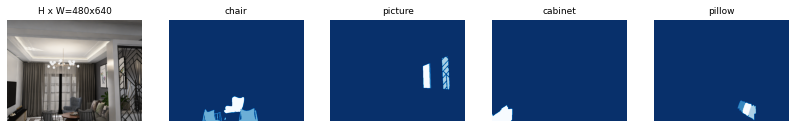

1267


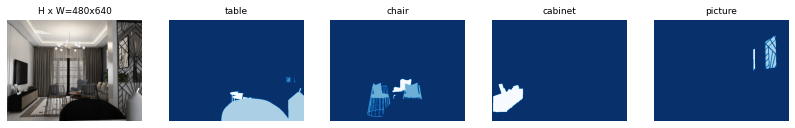

1260


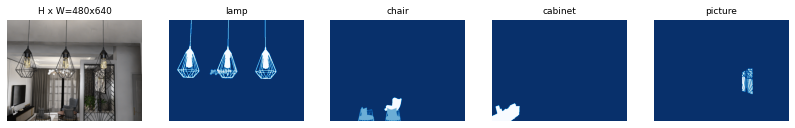

1268


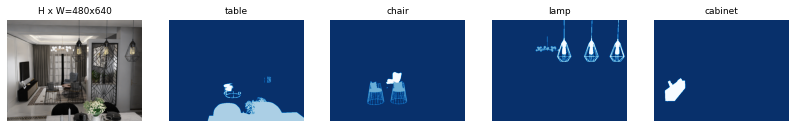

1258


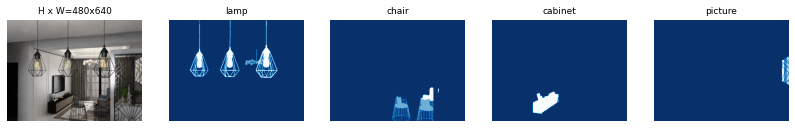

In [8]:
image_ids = dataset_train.load_view(5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [9]:
class InferenceConfig(interior_seq.InteriorNetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 2000
    VALIDATION_STEPS = 300
    NUM_CLASSES = len(selected_classes)  # background + num classes
    vmin = -1.07
    vmax = 1.07
    nvox = 40
    nvox_z = 40
    vsize = float(vmax - vmin) / nvox
    vox_bs = 1
    im_bs = 1
    samples = 10
    NUM_VIEWS = 2
    RECURRENT = False
    USE_RPN_ROIS = True
    LEARNING_RATE = 0.001
    GRID_REAS = 'ident'
    BACKBONE = 'resnet50'
    TOP_DOWN_PYRAMID_SIZE = 64
    VANILLA = False

config_stage1 = InferenceConfig()
config_stage1.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
GRID_REAS                      ident
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                35
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE       

In [10]:

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess= tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(sess)

# Create model in training mode
model = modellib.MaskRCNN(mode="inference", config=config_stage1,
                          model_dir=MODEL_DIR)
print(model.keras_model.summary())

# model_path = model.find_last()
# print(model_path)
from keras.engine import saving
import h5py
# f = h5py.File(os.path.join(model_path), mode='r')
f = h5py.File(os.path.join(MODEL_DIR, 'interiornet20200617T2352', 'backbone_sep.h5'), mode='r')
#f = h5py.File(COCO_MODEL_PATH, mode='r')
for layer in model.keras_model.layers:
    if layer.name == 'backbone':
        layers = layer.layers
        print(layer.__class__.__name__)
        saving.load_weights_from_hdf5_group_by_name(f, layer.layers)
        break
# model_path = model.find_last()
# print(model_path)
model_path = os.path.join(MODEL_DIR, 'interiornet20200618T0921', 'mask_rcnn_interiornet_0006.h5')
model.load_weights(model_path, by_name=True, exclude=["backbone"])
# model.load_weights(model_path, by_name=True)

input_image_0_shape: [None, 640, 640, 3]
shape of input: [640, 640, 3]
input_image_shape: [None, 640, 640, 3]
fn image_shape: [None, 640, 640, 3]
Instructions for updating:
Colocations handled automatically by placer.
shape_out: [None, 160, 160, 64]
shape_out: [None, 80, 80, 64]
shape_out: [None, 40, 40, 64]
shape_out: [None, 20, 20, 64]
shape_out: [None, 10, 10, 64]
finished whole bb model
finished
P2_t: [None, 1, 160, 160, 64]
P2_shape: [None, 2, 160, 160, 64]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
Instructions for updating:
Use tf.cast instead.
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shap

normal model
input_image
lambda_1
lambda_7
lambda_2
lambda_8
lambda_6
lambda_12
lambda_3
lambda_9
lambda_4
lambda_10
lambda_5
lambda_11
lambda_13
input_R
input_Kmat
lambda_17
lambda_14
lambda_15
lambda_16
unproj_P2
unproj_P6
unproj_P3
unproj_P4
unproj_P5
lambda_23
lambda_24
lambda_25
lambda_26
lambda_27
activation_44
activation_47
activation_50
activation_53
activation_56
grid_reas_P2ident_conv
grid_reas_P3ident_conv
grid_reas_P4ident_conv
grid_reas_P5ident_conv
grid_reas_P6ident_conv
grid_reas_P2_batch_norm
grid_reas_P3_batch_norm
grid_reas_P4_batch_norm
grid_reas_P5_batch_norm
grid_reas_P6_batch_norm
activation_45
activation_48
activation_51
activation_54
activation_57
activation_46
activation_49
activation_52
activation_55
activation_58
projs_PG2
projs_PG3
projs_PG4
projs_PG5
projs_PG6
lambda_28
lambda_29
lambda_30
lambda_31
lambda_32
grid_reas_depth_PG22DConv
grid_reas_depth_PG32DConv
grid_reas_depth_PG42DConv
grid_reas_depth_PG52DConv
grid_reas_depth_PG62DConv
grid_reas_depth_PG2b

[381 397]
(2, 480, 640, 3)
(1, 2, 3, 4)
(1, 3, 3)
(480, 640, 3)
new function


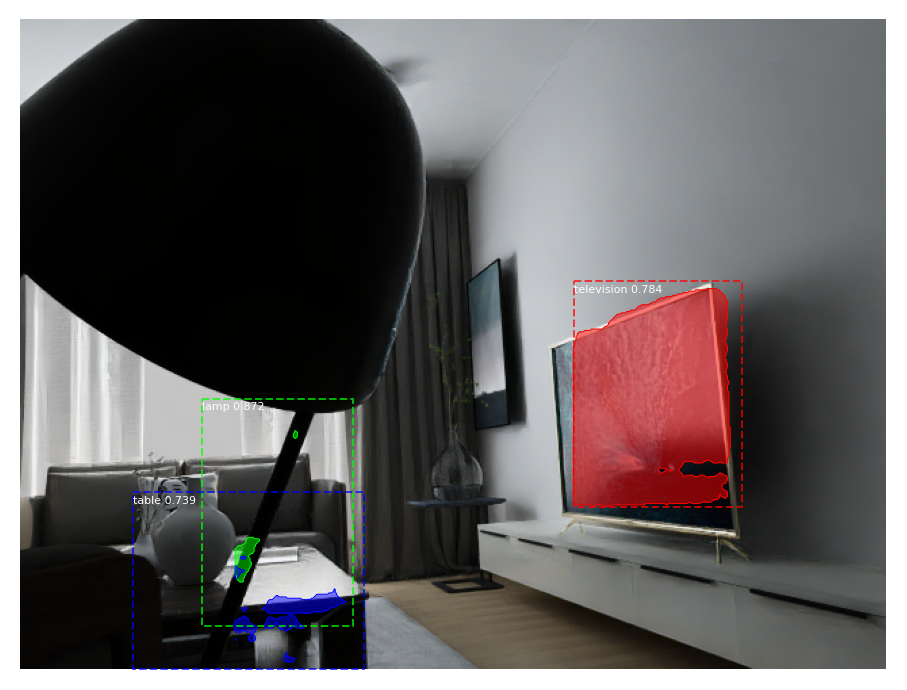

In [14]:
path = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD/test/3FO4MLNLVIOK_Bedroom/cam0/data/14.png'
SAVE_DIR = os.path.join(ROOT_DIR, 'data/Results/')

# image_ids = np.random.choice(dataset_train.image_ids, 20)
image_ids = np.asarray(dataset_val.load_view(2))
image_ids = np.array([381, 397])
print(image_ids)
image_pairs = image_ids.reshape([-1,config_stage1.NUM_VIEWS])
for image_pair in image_pairs:
    im = []
    Rcam = []
    Kmat = dataset_val.K
    for image_id in image_pair:
        im.append(dataset_val.load_image(image_id))
        Rcam.append(dataset_val.load_R(image_id))
        
    im = np.stack(im)
    Rcam = np.stack([Rcam])
    Kmat = np.stack([Kmat])
    print(im.shape)
    print(Rcam.shape)
    print(Kmat.shape)
    print(im[0].shape)
    results = model.detect([im], Rcam, Kmat)
    r = results[0]
    #for feature in r['mrcnn_features']
    #    key != 'q':
    #    plt.imshow()
    #    key = input()
        
    visualize.display_instances(im[0], r['rois'], r['masks'], r['class_ids'], 
                                selected_classes, r['scores'])
    visualize.save_image(image_name = image_ids[0], image = im[0], boxes = r['rois'], masks = r['masks'], class_ids = r['class_ids'], class_names = selected_classes, scores = r['scores'], save_dir = SAVE_DIR)



(160, 160, 64)
(160, 160, 64)


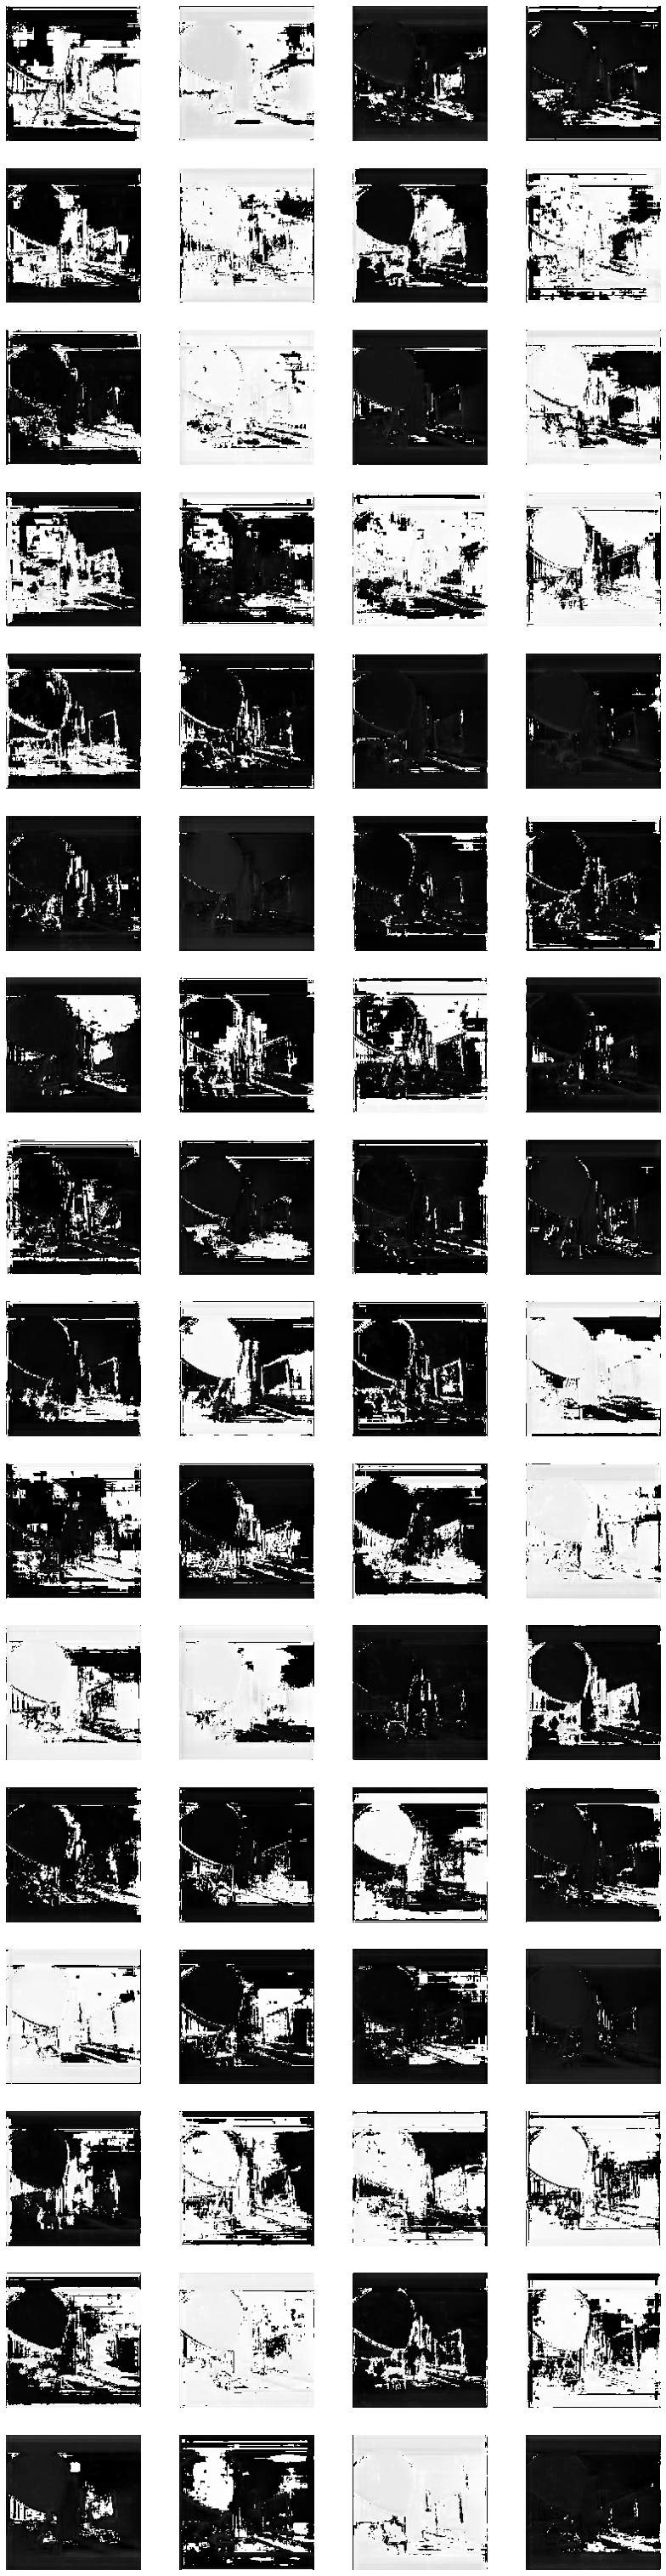

[[[  1.0462785   19.636034    23.85163    ...  29.322641     1.1558347
    16.420563  ]
  [ -6.5823693    6.386076    30.811008   ...  24.940737    -7.195849
    20.445036  ]
  [ -1.1602191    3.7348707   17.99937    ...  12.5977745  -14.810684
    22.866972  ]
  ...
  [-10.058669     8.105996    21.637642   ...   9.260412     2.3650546
    27.140512  ]
  [  0.26618153   9.770678    26.896376   ...   4.7902827   -3.3120694
    23.130247  ]
  [-11.665834     1.9736996   11.567824   ...   5.8975577   -5.5631256
    10.299642  ]]

 [[ 19.898571     8.256293    25.112286   ...  19.01199      7.0980763
    23.877928  ]
  [  1.2482276  -24.292799    37.688076   ...  38.05963     -7.423637
    29.864588  ]
  [ 11.66499    -19.421663    21.695187   ...  13.234413   -15.779401
    36.12346   ]
  ...
  [ -1.8519125   -8.334894    31.544283   ...  21.621       -1.0953097
    44.359737  ]
  [  0.28808886  -4.507721    41.874317   ...  21.17479     -7.3915043
    40.821735  ]
  [-17.153053   -13.20

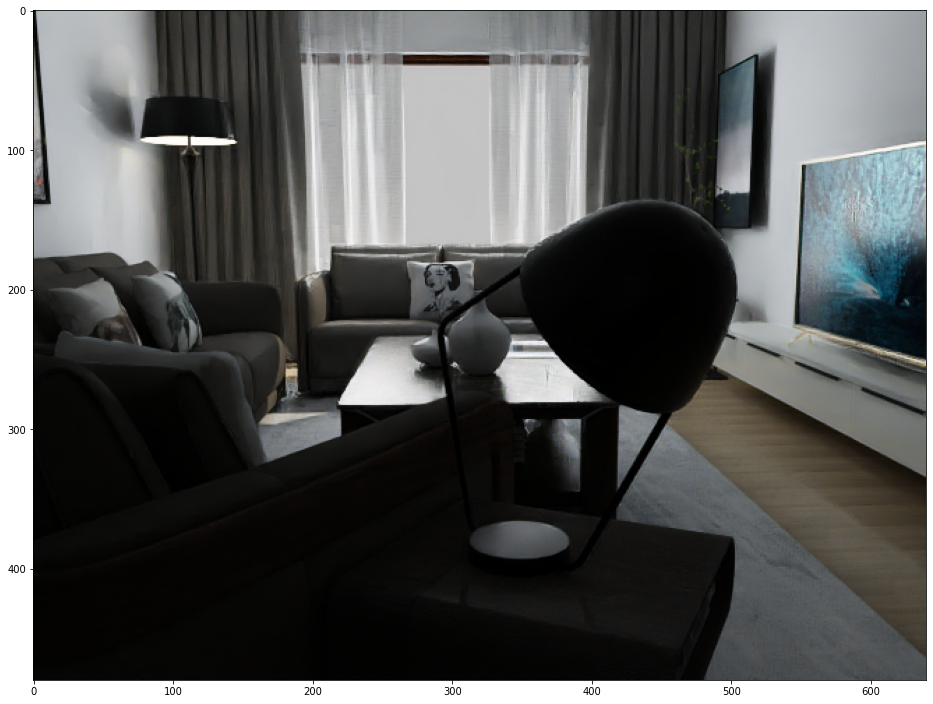

In [12]:
print(r['mrcnn_features'][:,:,:].shape)
print(r['mrcnn_intermediate_features'].transpose([1,2,0])[:,:,:].shape)

# display_images(np.transpose(r['mrcnn_intermediate_features'].transpose([1,2,0])[:,:,-64:], [2,0,1]),cmap='gray')
display_images(np.transpose(r['mrcnn_features'][:,:,:64], [2,0,1]),cmap='gray')
# display_images(np.transpose(r['mrcnn_features'][:,:,:64], [2,0,1]),cmap='gray')
ax = get_ax()
plt.imshow(im[1])
print(r['mrcnn_features'][:,:,:64])
#print(r['mrcnn_features'][:,:,270])
#plt.imshow(r['mrcnn_features'][:,:,250])


In [13]:
plt.imshow(im[2])


IndexError: index 2 is out of bounds for axis 0 with size 2